## ACCESS-OM2 SST and SST difference from WOA13

Related issue: https://github.com/ACCESS-Community-Hub/access-om3-25km-paper-1/issues/9

In [1]:
import xarray as xr
import cf_xarray as cfxr
import cf_xarray.units
import pint_xarray
from pint import application_registry as ureg
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client
import cftime
import os
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from textwrap import wrap
xr.set_options(keep_attrs=True);  # cf_xarray works best when xarray keeps attributes by default

In [2]:
client = Client(threads_per_worker=1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37745 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37745/status,
Dashboard: /proxy/37745/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42947,Workers: 0
Dashboard: /proxy/37745/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35783,Total threads: 1
Dashboard: /proxy/34993/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:32795,


### Define plot function

In [3]:
blue_marble = plt.imread('/g/data/ik11/grids/BlueMarble.tiff')
blue_marble_extent = (-180, 180, -90, 90)

In [4]:
def plot(dat, title=None, **kwargs):
    if title is None:
        title = dat.attrs['long_name']
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    dat.plot.contourf(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cbar_kwargs={"label": "\n".join(wrap(f"{dat.attrs['long_name']} [{dat.attrs['units']}]", 45)),
                     "fraction": 0.03, "aspect": 15, "shrink": 0.7},
        **kwargs
    )
    
    # Add blue marble land:
    ax.imshow(
        blue_marble, extent=blue_marble_extent, transform=ccrs.PlateCarree(), origin="upper"
    )
    
    plt.title(title);

### Load and plot data from ACCESS-OM2
use control - see https://forum.access-hive.org.au/t/access-om2-control-experiments/258#p-747-ryf-7

In [5]:
# exptname = '025deg_jra55_ryf9091_gadi'
exptname = '025deg_jra55_iaf_omip2_cycle1'
datastore = intake.cat.access_nri[exptname]

In [6]:
geolon = datastore.search(variable="geolon_t").to_dask().geolon_t
geolat = datastore.search(variable="geolat_t").to_dask().geolat_t

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [7]:
# for 025deg_jra55_ryf9091_gadi
# variable = "temp"  # NB: using top level of annual-mean 3D temp, as surface_temp not available for 025deg_jra55_ryf9091_gadi, and also has monthly data only for 1900-1903, and 2300-, with annual data in the gap
# frequency = "1yr"

# for 025deg_jra55_iaf_omip2_cycle1
variable = "sst"
frequency = "1mon"

model_all = datastore.search(variable=variable, frequency=frequency).to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    ),
    xarray_combine_by_coords_kwargs=dict(
        compat="override",
        data_vars="minimal",
        coords="minimal"
    )
)[variable].cf.assign_coords({ "longitude": geolon, "latitude": geolat })

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [8]:
if 'st_ocean' in model_all.coords:
    model_all = model_all.isel(st_ocean=0)

In [9]:
# for IAF
model_all = model_all.convert_calendar("proleptic_gregorian", use_cftime=True)

In [10]:
model_all.time.values[0] # initial date in data

cftime.DatetimeProlepticGregorian(1958, 1, 14, 12, 0, 0, 0, has_year_zero=True)

In [11]:
model_all.time.values[-1] # final date in data

cftime.DatetimeProlepticGregorian(2018, 12, 14, 12, 0, 0, 0, has_year_zero=True)

In [12]:
# set time range

# timerange = slice(cftime.DatetimeNoLeap(1942, 1, 1, 0, 0, 0, 0),
#                   cftime.DatetimeNoLeap(1952, 1, 1, 0, 0, 0, 0))
# timerange = slice(None, None)
datestop = cftime.DatetimeProlepticGregorian(1987, 12, 31, 12, 0, 0, 0, has_year_zero=True) # to match OM3 IAF run
datelist = list(cftime.to_tuple(datestop))
datelist[0] -= 10  # last 10 years
datestart = cftime.datetime(*datelist, calendar=datestop.calendar)
timerange = slice(datestart, datestop)

In [13]:
datestart

cftime.datetime(1977, 12, 31, 12, 0, 0, 0, calendar='proleptic_gregorian', has_year_zero=True)

In [14]:
datestop

cftime.DatetimeProlepticGregorian(1987, 12, 31, 12, 0, 0, 0, has_year_zero=True)

In [15]:
model_all = model_all.sel(time=timerange)

In [16]:
%%time
model = model_all.mean('time').load()

CPU times: user 1.05 s, sys: 4.37 s, total: 5.42 s
Wall time: 6.09 s


In [17]:
model = model.pint.quantify().pint.to('C').pint.dequantify()

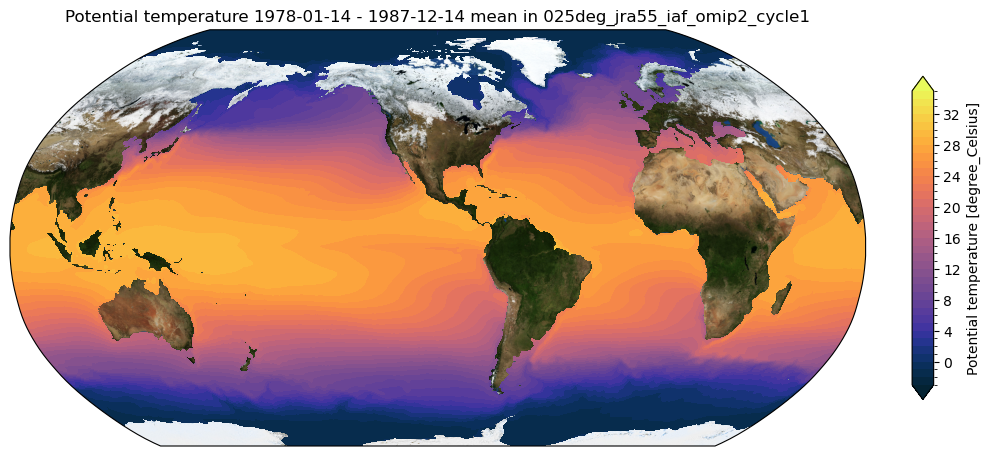

In [18]:
plot(model,
    levels=39,
    vmin=-3,
    vmax=35,
    extend="both",
    cmap=cm.cm.thermal,
    title=f"{model.attrs['long_name']} {model_all.time.values[0].strftime('%Y-%m-%d')} - {model_all.time.values[-1].strftime('%Y-%m-%d')} mean in {exptname}"
    )

### Load data from WOA13 (annual mean; Jan is ACCESS-OM2 initial condition)

In [19]:
obs = xr.open_mfdataset('/g/data/ik11/observations/woa13/025_KDS50/woa13_ts_*', 
                            chunks={'time': -1})['temp'].isel(ZT=0).mean('time').rename({'GRID_Y_T': 'yt_ocean', 'GRID_X_T': 'xt_ocean'}).load()
obs = obs.cf.assign_coords({ "longitude": geolon, "latitude": geolat })

/jobfs/149010139.gadi-pbs/ipykernel_3840195/4108794778.py:1: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  obs = xr.open_mfdataset('/g/data/ik11/observations/woa13/025_KDS50/woa13_ts_*',
/jobfs/149010139.gadi-pbs/ipykernel_3840195/4108794778.py:1: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silence this warning specify 'use_cftime=True'.
  obs = xr.open_mfdataset('/g/data/ik11/observations/woa13/025_KDS50/woa13_ts_*',
/jobfs/149010139.gadi-pbs/ipykernel_3840195/4108794778.py:1: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates prior reform date (1582-10-15). To silen

### Plot ACCESS-OM2 minus WOA13
First plot full range, then a sequence at specified ranges.

**BUG: WOA initial condition data is conservative temperature, but model data is potential temperature**

In [20]:
bias = (model - obs).load().cf.assign_coords({ "longitude": geolon, "latitude": geolat })

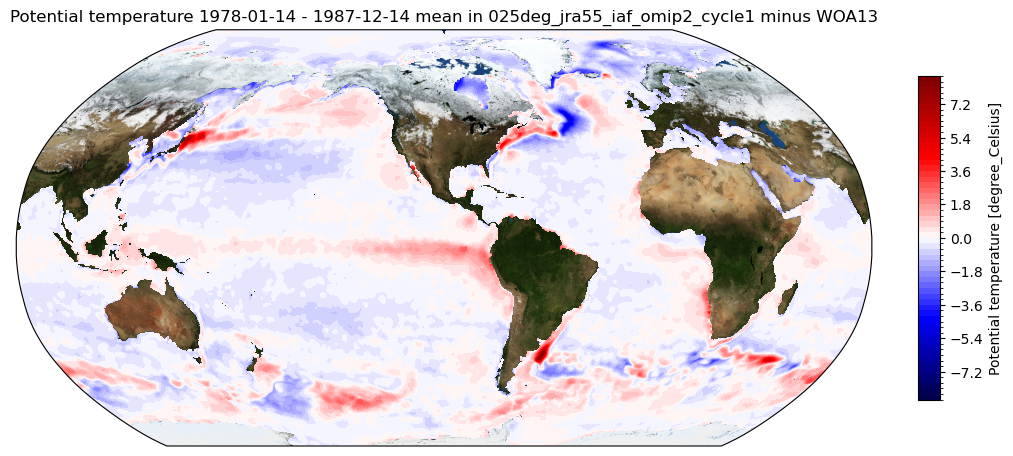

In [21]:
plot(bias,
    levels=61,
    cmap='seismic',
    title=f"{model.attrs['long_name']} {model_all.time.values[0].strftime('%Y-%m-%d')} - {model_all.time.values[-1].strftime('%Y-%m-%d')} mean in {exptname} minus WOA13"
    )

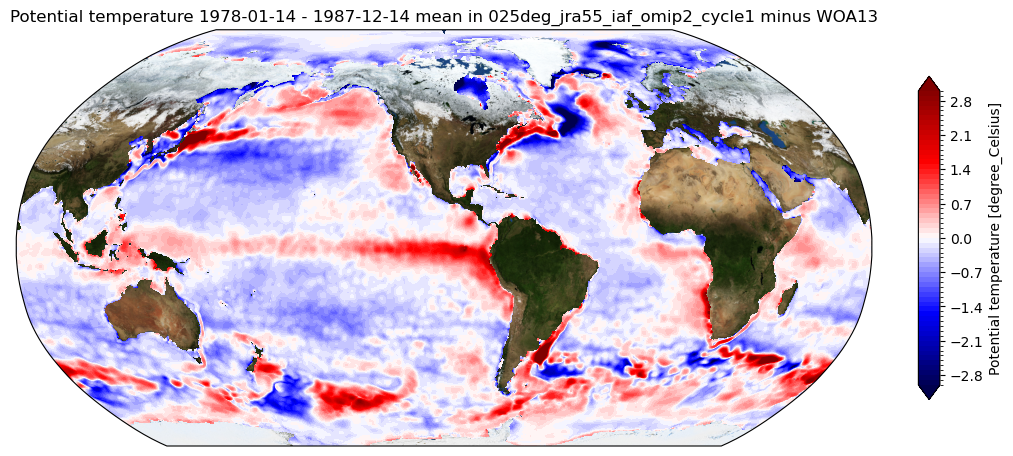

In [22]:
plot(bias,
    levels=61,
    vmin=-3,
    vmax=3,
    extend="both",
    cmap='seismic',
    title=f"{model.attrs['long_name']} {model_all.time.values[0].strftime('%Y-%m-%d')} - {model_all.time.values[-1].strftime('%Y-%m-%d')} mean in {exptname} minus WOA13"
    )

In [23]:
client.close()